Ce notebook va être consacré au preprocessing du dataset et l'entrainement d'un premier modèle simple pour établir une baseline.

---

# Load

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pandas display options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Team' : "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'NumberOfPitStops': np.uint8,
    'Position' : np.uint8,
    'GapToLeader' : np.float32,
    'IntervalToPositionAhead' : np.float32,
    'LapsToLeader' : np.uint8,
    'TotalLaps' : np.uint8,
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

years = range(2019, 2023)

In [2]:
data = pd.DataFrame()

for year in years:
    path = os.path.join(base_path, str(year), file_name)
    year_csv = pd.read_csv(
            path,
            dtype=type_dict,
    )
    year_csv['Year'] = year
    data = pd.concat([
        data,
        year_csv
    ])

# Preprocessing

In [3]:
## TrackStatus ----------------------------------------------------------------

def trackStatus_to_binary(df):
    trackStatus = df['TrackStatus']
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

def process_trackStatus(df):
    trackStatuses = df.apply(trackStatus_to_binary, axis=1)
    return pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1).reset_index(drop=True)

## Missing Data ----------------------------------------------------------------

def process_missing_values(df):
    # TODO fill the missing values better
    df.fillna({
        'DistanceToDriverAhead': 0,
        'GapToLeader': 0,
        'IntervalToPositionAhead': 0,
    }, inplace=True)

    # drop all rows with missing laptime
    df.dropna(subset=['LapTime'], inplace=True)
    return df[df['LapNumber'] > 1]

## Datatypes -------------------------------------------------------------------

def process_datatypes(df):
    # boolean
    df['Green'] = df['Green'].astype('bool')
    df['Yellow'] = df['Yellow'].astype('bool')
    df['SC'] = df['SC'].astype('bool')
    df['Red'] = df['Red'].astype('bool')
    df['VSC'] = df['VSC'].astype('bool')
    df['SC_ending'] = df['SC_ending'].astype('bool')
    df['IsAccurate'] = df['IsAccurate'].astype('bool')
    df['Rainfall'] = df['Rainfall'].astype('bool')
    # category
    df['DriverNumber'] = df['DriverNumber'].astype('category')
    df['Team'] = df['Team'].astype('category')
    df['Compound'] = df['Compound'].astype('category')
    df['DriverAhead'] = df['DriverAhead'].astype('category')
    df['Track'] = df['Track'].astype('category')
    # float
    df['LapStartTime'] = df['LapStartTime'].astype('float32')
    df['LapTime'] = df['LapTime'].astype('float32')
    df['DistanceToDriverAhead'] = df['DistanceToDriverAhead'].astype('float32')
    df['GapToLeader'] = df['GapToLeader'].astype('float32')
    df['IntervalToPositionAhead'] = df['IntervalToPositionAhead'].astype('float32')
    df['AirTemp'] = df['AirTemp'].astype('float32')
    df['Humidity'] = df['Humidity'].astype('float32')
    df['Pressure'] = df['Pressure'].astype('float32')
    df['TrackTemp'] = df['TrackTemp'].astype('float32')
    df['WindDirection'] = df['WindDirection'].astype('float32')
    df['WindSpeed'] = df['WindSpeed'].astype('float32')
    # int
    df['LapNumber'] = df['LapNumber'].astype('uint8')
    df['TyreLife'] = df['TyreLife'].astype('uint8')
    df['Stint'] = df['Stint'].astype('uint8')
    df['NumberOfPitStops'] = df['NumberOfPitStops'].astype('uint8')
    df['Position'] = df['Position'].astype('uint8')
    df['LapsToLeader'] = df['LapsToLeader'].astype('uint8')
    df['TotalLaps'] = df['TotalLaps'].astype('uint8')
    return df

## Add target ------------------------------------------------------------------

def process_target(df):
    df['is_pitting'] = df['PitStatus'] == 'InLap'
    df['is_pitting'] = df['is_pitting'].astype('bool')
    return df

## Remove features -------------------------------------------------------------

def process_remove_features(df):
    df.drop(['LapStartTime', 'DriverNumber', 'Team', 'DriverAhead', 
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed',
    'PitStatus', 'IsAccurate'], axis=1, inplace=True)
    return df

## Feature encoding ------------------------------------------------------------

from sklearn.preprocessing import OneHotEncoder

def process_feature_encoding(df):
    categorical_features = ['Compound', 'Track']
    one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    one_hot_encoder.fit(df[categorical_features])
    one_hot_encoded = one_hot_encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))
    print("One hot : ", one_hot_encoded.shape)
    print("Data : ", df.shape)
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df, one_hot_encoder

## Add features ----------------------------------------------------------------

def process_add_features(new_df, df=None):
    new_df['RacePercentage'] = new_df['LapNumber'] / new_df['TotalLaps']

    return new_df

In [4]:
def preprocess(df):
    print('Preprocessing data...', df.shape)
    df = process_trackStatus(df)
    print('TrackStatus processed...', df.shape)
    df = process_missing_values(df)
    print('Missing values processed...', df.shape)
    df = process_datatypes(df)
    print('Datatypes processed...', df.shape)
    df = process_target(df)
    print('Target processed...', df.shape)
    df = process_add_features(df)
    print('Features added...', df.shape)
    df = process_remove_features(df)
    print('Features removed...', df.shape)
    df, encoder = process_feature_encoding(df)
    print('Features encoded...', df.shape)
    return df, encoder

In [5]:
# see null values
#df[df.isna().any(axis=1)]


In [6]:
#print(df[df['Track_São Paulo'] == 1].shape)
#print(df[df['Track_Mexico City'] == 1].shape)
#print(df[df['Track_Spielberg'] == 1].shape)

In [7]:
#data.query('TotalLaps == 71').value_counts('Track')

In [5]:
df = data.copy()

In [6]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df, encoder = preprocess(train_df)
test_df, _ = preprocess(test_df)

Preprocessing data... (70276, 28)
TrackStatus processed... (70276, 33)
Missing values processed... (67709, 33)
Datatypes processed... (67709, 33)
Target processed... (67709, 34)
Features added... (67709, 35)
Features removed... (67709, 22)


p:\Anaconda\envs\bsc\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


One hot :  (67709, 40)
Data :  (67709, 22)
Features encoded... (67709, 60)
Preprocessing data... (17569, 28)
TrackStatus processed... (17569, 33)
Missing values processed... (16921, 33)
Datatypes processed... (16921, 33)
Target processed... (16921, 34)
Features added... (16921, 35)
Features removed... (16921, 22)
One hot :  (16921, 40)
Data :  (16921, 22)
Features encoded... (16921, 60)


p:\Anaconda\envs\bsc\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

X_train = train_df.drop(['is_pitting'], axis=1)
y_train = train_df['is_pitting']

X_test = test_df.drop(['is_pitting'], axis=1)
y_test = test_df['is_pitting']

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(65245, 59) (16299, 59) (65245,) (16299,)


# Evaluation  

In [10]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    
    

# Modelisation

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [12]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))


In [13]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())

In [14]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

In [ ]:
#for name, model in dict_of_models.items():
#    print(name)
#    evaluation(model)

In [15]:
model = RandomForestClassifier(random_state=0,
                               class_weight='balanced_subsample',
                               n_estimators=1000,
                               max_depth=10,
                               min_samples_split=2,
                               min_samples_leaf=1,)
model.fit(X_train, y_train)
ypred = model.predict(X_test)

print(confusion_matrix(y_test, ypred))
print(classification_report(y_test, ypred))

[[13561  2246]
 [  130   362]]
              precision    recall  f1-score   support

       False       0.99      0.86      0.92     15807
        True       0.14      0.74      0.23       492

    accuracy                           0.85     16299
   macro avg       0.56      0.80      0.58     16299
weighted avg       0.96      0.85      0.90     16299



# Test

In [16]:
# Load test data
test_data = pd.read_csv('data/2023/bahrain_grand_prix.csv'
                        , dtype=type_dict)

test_data['Year'] = 2023

In [17]:
test_df_44 = test_data.query('DriverNumber == "44"').copy()
test_df_44.head()

,LapStartTime,LapNumber,LapTime,DriverNumber,Team,Compound,TyreLife,TrackStatus,Stint,DistanceToDriverAhead,DriverAhead,PitStatus,IsAccurate,NumberOfPitStops,Position,GapToLeader,IntervalToPositionAhead,LapsToLeader,Track,TotalLaps,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Year
16,3756.652100,1,NaN,44,Mercedes,SOFT,4,2,1,NaN,NaN,OutLap,False,0,5,3.269,0.629,0,Sakhir,57,27.299999,22.0,1016.700012,False,31.299999,0.0,0.6,2023
24,3859.210938,2,99.166000,44,Mercedes,SOFT,5,2,1,50.203609,55,NoPit,True,0,5,4.480,0.864,0,Sakhir,57,27.299999,22.0,1016.700012,False,31.200001,190.0,0.6,2023
44,3958.376953,3,99.220001,44,Mercedes,SOFT,6,1,1,62.451946,55,NoPit,True,0,5,5.675,1.040,0,Sakhir,57,27.299999,22.0,1016.900024,False,31.100000,197.0,0.6,2023
64,4057.596924,4,99.197998,44,Mercedes,SOFT,7,1,1,81.827499,55,NoPit,True,0,5,6.897,1.253,0,Sakhir,57,27.299999,22.0,1016.700012,False,31.200001,170.0,0.6,2023
84,4156.794922,5,99.334999,44,Mercedes,SOFT,8,1,1,100.092499,55,NoPit,True,0,5,8.197,1.460,0,Sakhir,57,27.200001,22.0,1016.900024,False,31.100000,236.0,0.8,2023


In [18]:
def process_feature_encoding_new(df, encoder):
    categorical_features = ['Compound', 'Track']
    one_hot_encoded = encoder.transform(df[categorical_features])
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_features))
    df = df.join(one_hot_encoded)
    df.drop(categorical_features, axis=1, inplace=True)
    return df

def preprocess_new_data(new_df, df, encoder):
    print('Preprocessing data...', new_df.shape)
    new_df = process_trackStatus(new_df)
    print('TrackStatus processed...', new_df.shape)
    new_df = process_missing_values(new_df)
    print('Missing values processed...', new_df.shape)
    new_df = process_datatypes(new_df)
    print('Datatypes processed...', new_df.shape)
    new_df = process_target(new_df)
    print('Target processed...', df.shape)
    new_df = process_add_features(new_df, df)
    print('Features added...', df.shape)
    new_df = process_remove_features(new_df)
    print('Features removed...', df.shape)
    new_df = process_feature_encoding_new(new_df, encoder)
    print('Features encoded...', new_df.shape)
    return new_df

In [19]:
test_df_44 = preprocess_new_data(test_df_44, data, encoder)

test_df_44.dropna(inplace=True)

test_df_44.head()

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (56, 60)


,LapNumber,LapTime,TyreLife,Stint,DistanceToDriverAhead,NumberOfPitStops,Position,GapToLeader,IntervalToPositionAhead,LapsToLeader,TotalLaps,Year,Green,Yellow,SC,Red,VSC,SC_ending,is_pitting,RacePercentage,Compound_HARD,Compound_INTERMEDIATE,Compound_MEDIUM,Compound_SOFT,Compound_WET,Track_Abu Dhabi,Track_Al Daayen,Track_Austin,Track_Baku,Track_Barcelona,Track_Budapest,Track_Hockenheim,Track_Imola,Track_Istanbul,Track_Jeddah,Track_Le Castellet,Track_Marina Bay,Track_Melbourne,Track_Mexico City,Track_Miami,Track_Monaco,Track_Monte-Carlo,Track_Montmeló,Track_Montreal,Track_Montréal,Track_Monza,Track_Mugello,Track_Nürburg,Track_Portimão,Track_Sakhir,Track_Shanghai,Track_Silverstone,Track_Sochi,Track_Spa,Track_Spa-Francorchamps,Track_Spielberg,Track_Suzuka,Track_São Paulo,Track_Yas Island,Track_Zandvoort
1,2,99.166000,5,1,50.203609,0,5,4.480,0.864,0,57,2023,False,True,False,False,False,False,False,0.035088,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,99.220001,6,1,62.451946,0,5,5.675,1.040,0,57,2023,True,False,False,False,False,False,False,0.052632,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,99.197998,7,1,81.827499,0,5,6.897,1.253,0,57,2023,True,False,False,False,False,False,False,0.070175,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,99.334999,8,1,100.092499,0,5,8.197,1.460,0,57,2023,True,False,False,False,False,False,False,0.087719,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,99.755997,9,1,106.815834,0,5,9.967,1.742,0,57,2023,True,False,False,False,False,False,False,0.105263,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
x_test_44 = test_df_44.drop('is_pitting', axis=1)
y_test_44 = test_df_44['is_pitting']

print(x_test_44.shape, y_test_44.shape)

(55, 59) (55,)


In [21]:
ypred_44 = model.predict(x_test_44)

print(confusion_matrix(y_test_44, ypred_44))
print(classification_report(y_test_44, ypred_44))

[[49  4]
 [ 0  2]]
              precision    recall  f1-score   support

       False       1.00      0.92      0.96        53
        True       0.33      1.00      0.50         2

    accuracy                           0.93        55
   macro avg       0.67      0.96      0.73        55
weighted avg       0.98      0.93      0.94        55



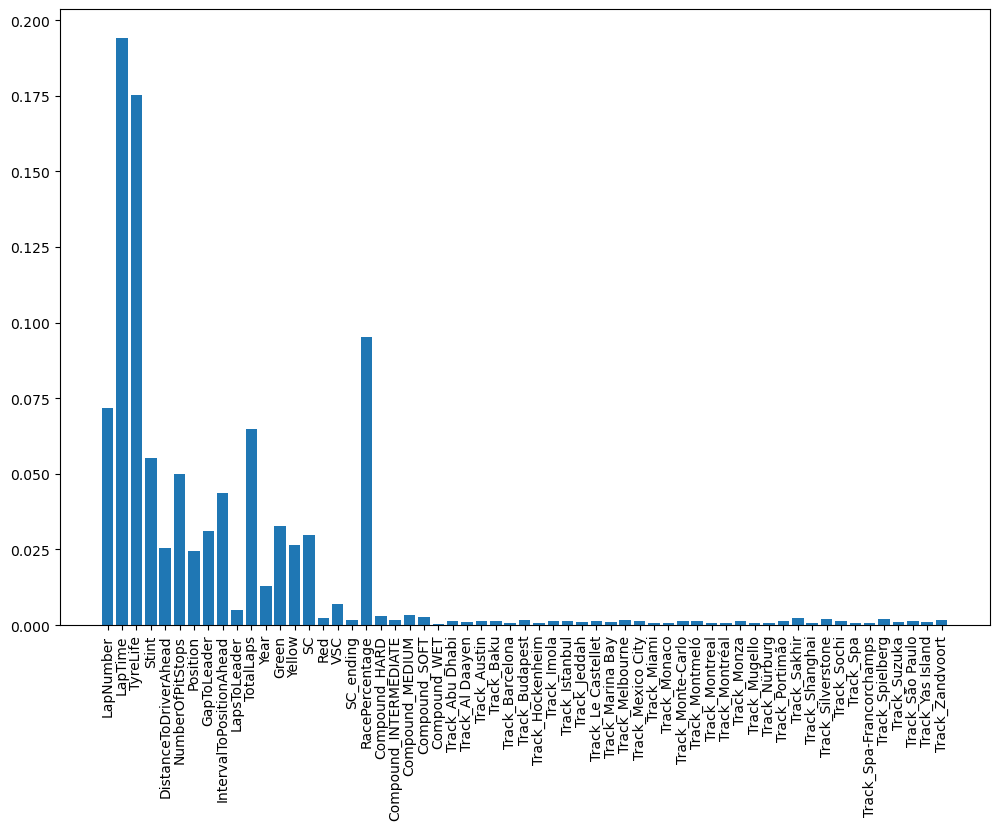

In [22]:
plt.figure(figsize=(12, 8))
plt.bar(x_test_44.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

In [23]:
import matplotlib.patches as mpatches
def plot_predictions_by_lapNumber(x_test, y_test, ypred, title=None):
    sns.set_style('darkgrid')
    plt.figure(figsize=(12, 2.5))
    sns.scatterplot(x=x_test['LapNumber'], y=0, hue=y_test, palette='Set1', marker='o')
    sns.scatterplot(x=x_test['LapNumber'], y=0.5, hue=ypred, palette='Set1', marker='o')
    plt.yticks([0, 0.5], ['Actual', 'Predicted'])
    plt.xlabel('Lap Number')
    plt.xticks(np.arange(0, x_test['TotalLaps'].max(), 5))
    plt.ylim(-0.5, 1)
    patch = mpatches.Patch(color='cornflowerblue', label='Pit stop')
    patch2 = mpatches.Patch(color='crimson', label='No pit stop')
    plt.legend(handles=[patch, patch2])
    if title:
        plt.title(title)
    plt.show()

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (56, 60)


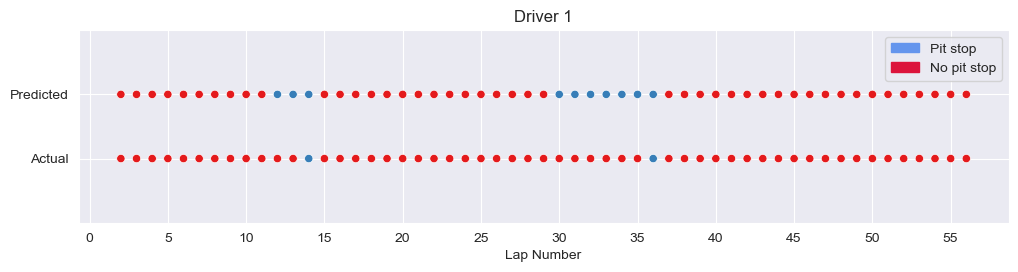

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (56, 60)


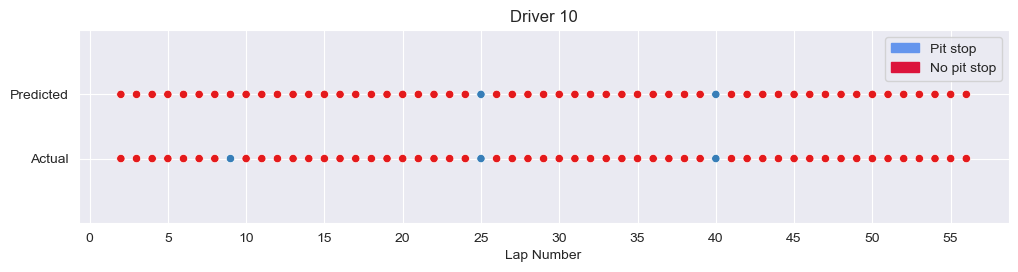

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (56, 60)


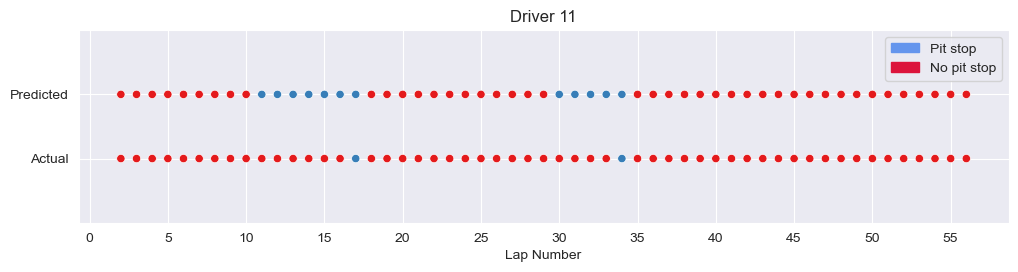

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (55, 33)
Datatypes processed... (55, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (55, 60)


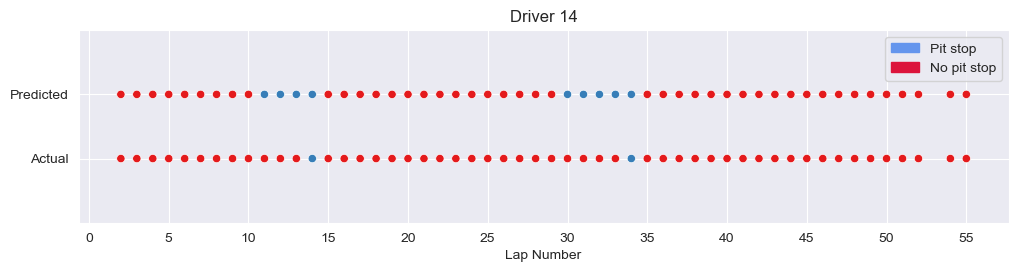

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (56, 60)


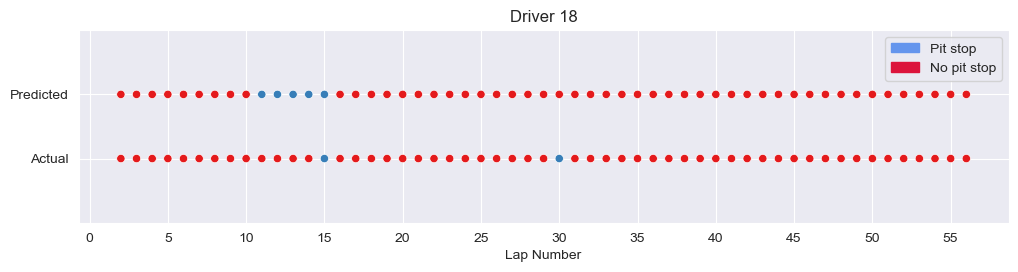

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (56, 60)


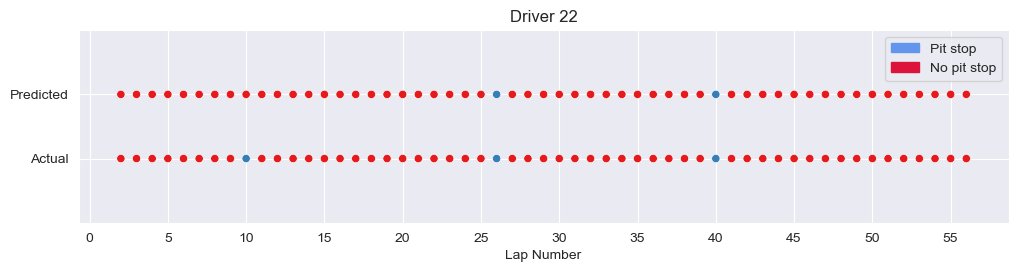

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (56, 60)


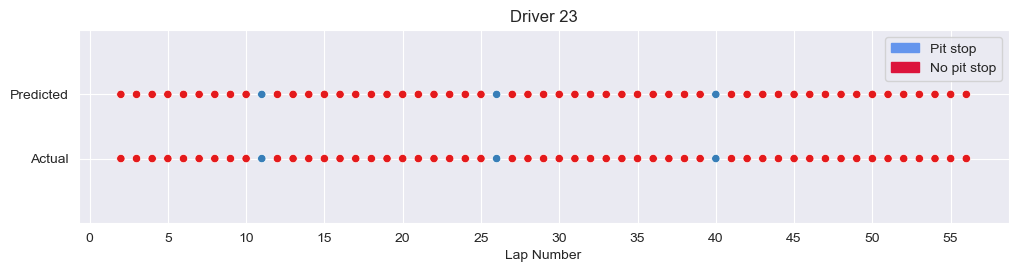

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (56, 60)


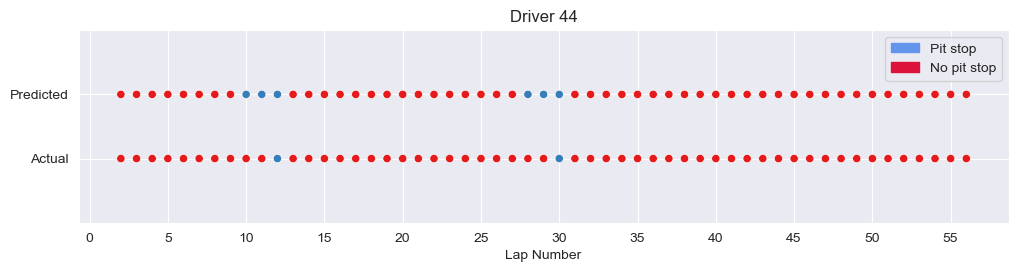

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (56, 60)


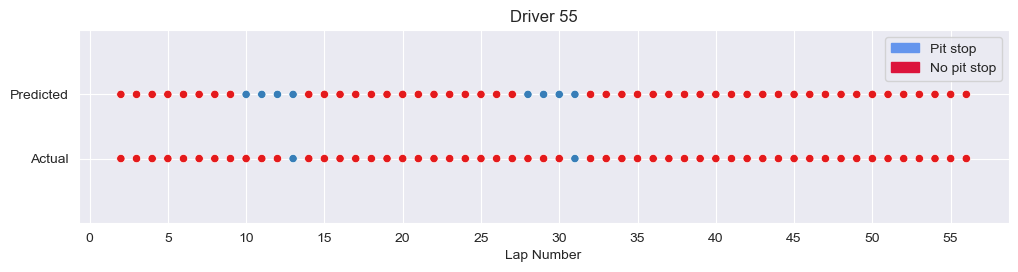

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (56, 60)


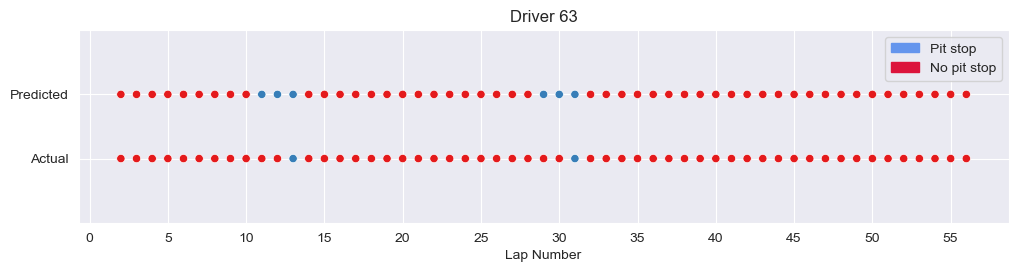

Preprocessing data... (57, 28)
TrackStatus processed... (57, 33)
Missing values processed... (56, 33)
Datatypes processed... (56, 33)
Target processed... (87845, 28)
Features added... (87845, 28)
Features removed... (87845, 28)
Features encoded... (56, 60)


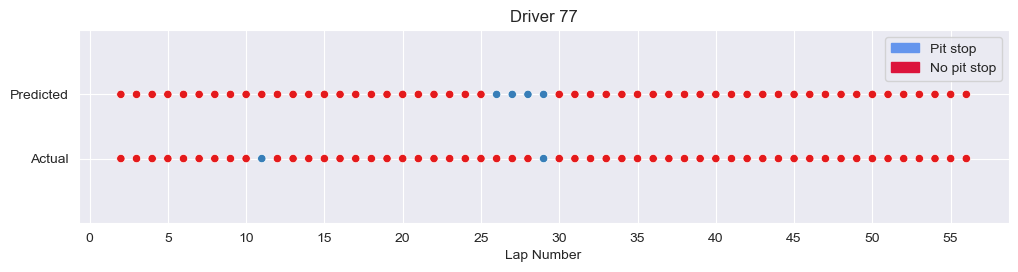

In [25]:
test_drivers = test_data.groupby('DriverNumber').agg({'LapNumber': 'max', 'TotalLaps': 'max'}).query('LapNumber == TotalLaps').index

for driver in test_drivers:
    test_df = test_data.query(f'DriverNumber == "{driver}"').copy()
    test_df = preprocess_new_data(test_df, df, encoder)
    test_df.dropna(inplace=True)
    x_test = test_df.drop('is_pitting', axis=1)
    y_test = test_df['is_pitting']
    ypred = model.predict(x_test)
    plot_predictions_by_lapNumber(x_test, y_test, ypred, title=f'Driver {driver}')